In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline
plt.style.use('seaborn')

In [2]:
df_raw = pd.read_csv('data/wa_ev_registrations_public.csv')
df_raw = df_raw[(df_raw.Technology == 'BEV')]
df_raw.head()
df_raw['Vehicle Name'].value_counts()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Tesla Model 3                521229
Nissan Leaf                  494796
Tesla Model S                249823
Tesla Model Y                142192
Chevrolet Bolt EV            128566
Tesla Model X                115386
Volkswagen e-Golf             33621
Kia Soul EV                   31295
BMW i3                        30029
Fiat 500e                     28154
Kia Niro EV                   22125
Audi e-tron                   13649
Ford Focus EV                 12971
Smart forTwo EV               10045
Chevrolet Spark                9209
Ford Mustang Mach-E            7492
Hyundai Kona Electric          7146
Volkswagen ID.4                6687
Jaguar I-Pace                  5458
Mercedes B-Class Electric      3916
Mini Hardtop 2 Door EV         3614
Volvo XC40 Recharge            3526
Porsche Taycan                 3508
Mitsubishi i                   3429
Tesla Roadster                 2961
Toyota RAV4 EV                 2507
Polestar 2                     1928
Audi e-tron Sportback       

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2010-01-06,1.0
2010-02-03,1.0
2010-02-11,1.0
2010-02-16,3.0
2010-03-03,1.0
...,...
2022-02-25,62758.0
2022-03-16,66305.0
2022-04-26,67786.0


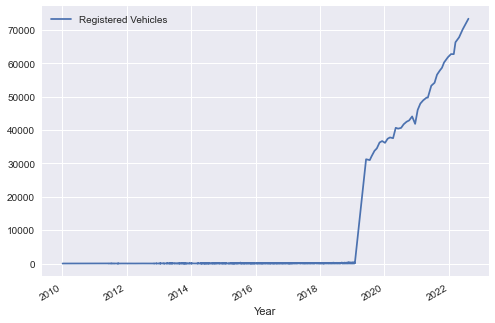

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

In [5]:
df.shape

(2381, 1)

In [6]:
# df.shift(2).shape

In [7]:
# df = pd.DataFrame(np.hstack((df.values.reshape(-1,1),
#                             df.shift().values.reshape(-1,1),
#                             df.shift(periods=2).values.reshape(-1,1))),
#                         columns = ['Original', '1 shift', '2 shifts'])
# df.head()

In [8]:
print(np.sqrt(mean_squared_error(df['Original'][1:], df['1 shift'][1:])))
print(np.sqrt(mean_squared_error(df['Original'][2:], df['2 shifts'][2:])))

KeyError: 'Original'

In [ ]:
auto_model = pm.auto_arima(df, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())


## **RESAMPLING

In [ ]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [ ]:
# # Backfill 
# df = df.resample('M').bfill()
# df.plot()

In [ ]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [ ]:
adtest = adfuller(df)
display(adtest)

In [ ]:
Stationary

## Modeling

In [ ]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2018-06-30':'2020-12-31']
test = df['2020-12-31':]
combined = df

test

In [ ]:
naive = train.shift(1)
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

In [ ]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



### The best model is :  ARIMA (1,0,0) (0,0,0) [0]

In [ ]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [ ]:
pred = output.get_prediction(start=pd.to_datetime('2021-01-31'), end=pd.to_datetime('2022-08-31'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

In [ ]:
sns.set_style(style='white')

rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in millions) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Washington Performance Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [ ]:
# Beginning our forecasting for next 3 years (36 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

In [ ]:
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Observed')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightblue',
                label='Confidence Interval')
scale_y = 1e6
ax.legend() 
plt.ylabel("Amount of registered vehicles")
plt.title('Forecast of Registered EVs in CA')
plt.show()